In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import csv

def organize_graph_and_add_weight(file_path, label):
    """Your graph preprocessor — same as you have."""
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x

import torch
import pandas as pd

def get_important_edges_from_npy(
    npy_file,
    model, 
    device
):
    """
    Load a graph from .npy, run GAT, compute Attention × Gradient importance.
    Return both the DataFrame and the encoded_matrix!
    """
    # === Load graph ===
    data = np.load(npy_file, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    # Build PyG Data
    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0] 
    y = torch.tensor([1.0], dtype=torch.float32)

    from torch_geometric.data import Data
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    batch = torch.zeros(graph.x.size(0), dtype=torch.long)

    graph = graph.to(device)
    batch = batch.to(device)

    graph.batch = batch

    graph.edge_attr = graph.edge_attr.detach().clone().requires_grad_(True)
    
    # === Forward pass ===
    output = model(graph)
    edge_index = graph.edge_index
    # For a unified downstream path, treat edge weights as "alpha"
    alpha = graph.edge_attr

    # === Backward ===
    model.zero_grad()
    output[0].backward()

    alpha_importance = alpha * alpha.grad

    edge_src = edge_index[0].cpu().numpy().reshape(-1)
    edge_dst = edge_index[1].cpu().numpy().reshape(-1)
    #attention = alpha.detach().cpu().numpy().reshape(-1)
    grad = alpha.grad.detach().cpu().numpy().reshape(-1)
    importance = alpha_importance.detach().cpu().numpy().reshape(-1)

    df = pd.DataFrame({
        'source': edge_src,
        'target': edge_dst,
        #'attention': attention,
        'grad': grad,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    return df, encoded_matrix



In [2]:
def get_edge_node_features(df, encoded_matrix, top_k=5):
    biggest_set = [
        # Carbon (C) subtypes
        'C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG', 'CG1', 'CG2', 'CH2', 'CZ', 'CZ2', 'CZ3',

        # Oxygen (O) subtypes
        'O', 'OH', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1',

        # Nitrogen (N) subtypes
        'N', 'NE', 'NE1', 'NE2', 'ND1', 'ND2', 'NZ', 'NH1', 'NH2',

        # Sulfur (S) subtypes
        'SD', 'SG'
    ]
    biggest_set.append('UNKNOWN')

    rows = []
    for _, row in df.head(top_k).iterrows():
        src_idx = int(row['source'])
        tgt_idx = int(row['target'])

        src_feat = encoded_matrix[src_idx]
        tgt_feat = encoded_matrix[tgt_idx]

        # Decode one-hot vector back to atom name
        def decode_one_hot(vector):
            idx = vector.argmax()
            return biggest_set[idx] if idx < len(biggest_set) else "INVALID"

        rows.append({
            'source_idx': src_idx,
            'target_idx': tgt_idx,
            #'attention': row['attention'],
            'grad': row['grad'],
            'importance': row['importance'],
            'source_features': src_feat,
            'target_features': tgt_feat,
            'source_atom': decode_one_hot(src_feat),
            'target_atom': decode_one_hot(tgt_feat)
        })

    return rows

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from Bio.PDB import PDBParser

# === Helpers ===
biggest_set = [
    'C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG', 'CG1', 'CG2', 'CH2', 'CZ', 'CZ2', 'CZ3',
    'O', 'OH', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1',
    'N', 'NE', 'NE1', 'NE2', 'ND1', 'ND2', 'NZ', 'NH1', 'NH2',
    'SD', 'SG', 'UNKNOWN'
]

def decode_one_hot(vector):
    idx = vector.argmax()
    return biggest_set[idx] if idx < len(biggest_set) else "INVALID"

def get_atom_coords_and_residues(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("mol", pdb_file)
    atoms = []

    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.is_disordered():
                        # Add ALL conformers (A, B, etc.)
                        for alt_atom in atom.disordered_get_list():
                            atoms.append(alt_atom)
                    else:
                        atoms.append(atom)

    #print(f"Total atoms extracted: {len(atoms)}")
    coords = [atom.coord for atom in atoms]
    residues = [atom.get_parent().get_resname() for atom in atoms]
    resid_numbers = [atom.get_parent().get_id()[1] for atom in atoms]
    return coords, residues, resid_numbers

def euclidean_distance(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)

atom_counts_per_exp   = []   # list[Counter]
residue_counts_per_exp= []   # list[Counter]
distances_per_exp     = []   # list[list[float]]

In [4]:
# pre load models
def load_GCN(model_checkpoint, in_channels, out_channels, device):
    model = GCN(input_dim=37)
    state_dict = torch.load(model_checkpoint, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    return model

def natural_sort_key(s):
    """Function to sort strings in a natural alphanumeric order."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_models = []

model_pattern = '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp1 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp1)

model_pattern = '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp2/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp2 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp2)

model_pattern = '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp3/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp3 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp3)

model_pattern = '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp4/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp4 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp4)

model_pattern = '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp5/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp5 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp5)

['/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_1.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_2.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_3.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_4.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_5.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_6.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_7.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_8.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_9.pth', '/home/alexhernandez/transmembranebindingAI/Models/Cholesterol/

In [5]:
for exp_index, experiment_models in enumerate(all_models[:1]):
    atom_subtype_counter = Counter()
    residue_type_counter = Counter()
    distance_list = []
    edge_records = []  # put this BEFORE your big loops

    npy_files = glob.glob(f'/home/alexhernandez/transmembranebindingAI/Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp{exp_index + 1}/Test/Unlabeled/*.npy')
    #npy_files.extend(glob.glob(f'/home/alexhernandez/transmembranebindingAI/Data/SplitData/Cholesterol/IvanTestSet/ivan-separate-graphs-5A/positive/*.npy'))
    for index, npy_file in enumerate(npy_files):
        if index % 10 == 0:
            print("Progress:", index, "/", len(npy_files))

        basename = os.path.basename(npy_file)
        if "ivan" in npy_file:
            pdb_file = f"../GNN/ivan-pdbs-distinct-5A/positive/{basename[:4]}-filtered.pdb"
        else:
            pdb_file = f"../GNN/filtered-pdbs-distinct-5A/unlabeled/{basename[:7]}.pdb"

        edge_counts = Counter()  # key: (min_idx, max_idx) -> count
        # Keep stats for tie-breaks and metadata
        edge_stats = defaultdict(lambda: {
            "importances": [],
            "grads": [],
            "src_atom": None,
            "tgt_atom": None,
        })

        coords, residues, residue_ids = get_atom_coords_and_residues(pdb_file)

        for model_index, model in enumerate(experiment_models):
            df, encoded_matrix = get_important_edges_from_npy(
                npy_file=npy_file,
                model=model,
                device=device
            )

            rows = get_edge_node_features(df, encoded_matrix, top_k=1000)

            for r in rows:
                u = int(r['source_idx'])
                v = int(r['target_idx'])
                a, b = (u, v) if u < v else (v, u)  # undirected canonical key
                edge_counts[(a, b)] += 1

                # collect stats for tie-breaking & later reporting
                s = edge_stats[(a, b)]
                s["importances"].append(float(r.get("importance", 0.0)))
                s["grads"].append(float(r.get("grad", 0.0)))
                # store atom subtypes (last write wins; these should be consistent per node)
                s["src_atom"] = r.get("source_atom", s["src_atom"])
                s["tgt_atom"] = r.get("target_atom", s["tgt_atom"])
        if edge_counts:
            # ---------- compute per-sample mean importances over ALL candidate edges ----------
            # mean importance for every (a,b) this sample produced across models
            mean_imp_per_edge = {}
            for k, s in edge_stats.items():
                imps = s["importances"]
                mean_imp_per_edge[k] = float(np.mean(imps)) if imps else 0.0

            # sample-wise min-max params
            all_means = np.array(list(mean_imp_per_edge.values()), dtype=float)
            imp_min = float(np.min(all_means)) if all_means.size else 0.0
            imp_max = float(np.max(all_means)) if all_means.size else 0.0
            range_eps = imp_max - imp_min

            def norm_imp(raw):
                # normalize to [0,1] per sample
                if range_eps <= 1e-12:
                    # degenerate case: all edges have same mean importance
                    # put them at 1.0 to avoid zeroing signal
                    return 1.0
                return (raw - imp_min) / range_eps

            # ---------- choose the highest-importance representative per residue pair ----------
            best_edge_for_pair = {}  # key: ('ILE','LEU') -> dict(record_for_that_pair)

            # Only now update your counters and edge_records with these 5 edges (once per edge)
            for (a, b) in edge_counts.keys():
                # safe lookups
                src = a
                tgt = b

                src_res = residues[src] if src < len(residues) else "UNK"
                tgt_res = residues[tgt] if tgt < len(residues) else "UNK"

                # build an undirected residue-type key, e.g., ('ILE','LEU')
                res_pair_key = tuple(sorted((src_res, tgt_res)))

                # mean importance (optional but handy to store)
                mean_importance_raw = mean_imp_per_edge.get((a, b), 0.0)
                mean_importance_norm = norm_imp(mean_importance_raw)

                # frequency across models
                freq = int(edge_counts[(a, b)])

                # atoms (safe lookups)
                s = edge_stats[(a, b)]
                src_atom = s["src_atom"] if s["src_atom"] is not None else "UNK"
                tgt_atom = s["tgt_atom"] if s["tgt_atom"] is not None else "UNK"

                # distance
                dist = euclidean_distance(np.array(coords[src]), np.array(coords[tgt]))

                candidate = {
                    "src_atom": src_atom,
                    "tgt_atom": tgt_atom,
                    "src_res": src_res,
                    "tgt_res": tgt_res,
                    "importance": float(mean_importance_norm),
                    "importance_raw": float(mean_importance_raw),
                    "distance": float(dist),
                    "frequency": freq,
                    "edge_key": (a, b),  # keep if you want to reference the actual nodes
                    "sample_file": basename,
                }

                src_res_id = residue_ids[src]
                tgt_res_id = residue_ids[tgt]

                if dist < 4.0 or src_res_id == tgt_res_id:
                    continue
                prev = best_edge_for_pair.get(res_pair_key)
                if prev is None:
                    best_edge_for_pair[res_pair_key] = candidate
                else:
                    # Keep the one with higher normalized importance.
                    # Tie-breakers: higher frequency, then shorter distance.
                    if (
                        (candidate["importance"] > prev["importance"])
                    ):
                        best_edge_for_pair[res_pair_key] = candidate

                        # ---------- select up to 5 per sample (optional cap), sorted by your preference ----------
                        # keep only edges with distance ≥ 4 Å
            candidates = [r for r in best_edge_for_pair.values() if r["distance"] >= 4.0]
                        # ----- diagnostics: BEFORE top-5 cap -----
            # pick up to 5 by highest normalized importance
            chosen_records = sorted(candidates, key=lambda r: -r["importance"])[:5]

            # ---------- update counters and save records ----------
            for rec in chosen_records:
                # Update counters ONCE per selected residue pair
                atom_subtype_counter[rec["src_atom"]] += 1
                atom_subtype_counter[rec["tgt_atom"]] += 1
                residue_type_counter[rec["src_res"]] += 1
                residue_type_counter[rec["tgt_res"]] += 1
                distance_list.append(rec["distance"])

                #if rec["distance"] >= 4.0:
                #print(rec["src_res"], rec["tgt_res"], rec["distance"], rec["importance"], npy_file, "is npy file")

                # Save final record (drop raw if you don’t need it)
                edge_records.append({
                    "src_atom": rec["src_atom"],
                    "tgt_atom": rec["tgt_atom"],
                    "src_res": rec["src_res"],
                    "tgt_res": rec["tgt_res"],
                    "importance": rec["importance"],      # normalized per sample
                    "importance_raw": rec["importance_raw"],
                    "distance": rec["distance"],
                    "frequency": rec["frequency"],
                    "sample_file": rec["sample_file"],
                })
                # ------------------------------------------------------

    atom_counts_per_exp.append(atom_subtype_counter)
    residue_counts_per_exp.append(residue_type_counter)
    distances_per_exp.append(distance_list)

Progress: 0 / 554
Progress: 10 / 554
Progress: 20 / 554
Progress: 30 / 554
Progress: 40 / 554
Progress: 50 / 554
Progress: 60 / 554
Progress: 70 / 554
Progress: 80 / 554
Progress: 90 / 554
Progress: 100 / 554
Progress: 110 / 554
Progress: 120 / 554
Progress: 130 / 554
Progress: 140 / 554
Progress: 150 / 554
Progress: 160 / 554
Progress: 170 / 554
Progress: 180 / 554
Progress: 190 / 554
Progress: 200 / 554
Progress: 210 / 554
Progress: 220 / 554
Progress: 230 / 554
Progress: 240 / 554
Progress: 250 / 554
Progress: 260 / 554
Progress: 270 / 554
Progress: 280 / 554
Progress: 290 / 554
Progress: 300 / 554
Progress: 310 / 554
Progress: 320 / 554
Progress: 330 / 554
Progress: 340 / 554
Progress: 350 / 554
Progress: 360 / 554
Progress: 370 / 554
Progress: 380 / 554
Progress: 390 / 554
Progress: 400 / 554
Progress: 410 / 554
Progress: 420 / 554
Progress: 430 / 554
Progress: 440 / 554
Progress: 450 / 554
Progress: 460 / 554
Progress: 470 / 554
Progress: 480 / 554
Progress: 490 / 554
Progress: 5

In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# ===== Helpers to save/load =====
def save_counters_to_csv(counters, filename):
    """
    counters: list of Counter objects (one per experiment)
    Saves to CSV with __experiment__ column + one column per key
    """
    df = pd.DataFrame(counters).fillna(0).astype(int)
    df.insert(0, "__experiment__", np.arange(1, len(df)+1))
    df.to_csv(filename, index=False)

def load_counters_from_csv(filename):
    """
    Loads CSV back into list of Counter dicts
    """
    df = pd.read_csv(filename)
    counters = []
    for _, row in df.iterrows():
        c = {col: int(row[col]) for col in df.columns if col != "__experiment__"}
        counters.append(c)
    return counters

def save_hists_to_csv(hists, bin_edges, filename):
    """
    hists: list of per-experiment hist arrays
    bin_edges: numpy array of bin edges
    Saves counts with __experiment__ + bin columns labeled by bin center
    """
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    df = pd.DataFrame(hists, columns=[f"bin_{c:.1f}" for c in bin_centers])
    df.insert(0, "__experiment__", np.arange(1, len(df)+1))
    df.to_csv(filename, index=False)

def load_hists_from_csv(filename):
    """
    Loads histogram CSV back into list of arrays + bin centers
    """
    df = pd.read_csv(filename)
    bin_cols = [c for c in df.columns if c != "__experiment__"]
    hists = df[bin_cols].to_numpy()
    bin_centers = [float(c.replace("bin_", "")) for c in bin_cols]
    return hists, np.array(bin_centers)

# # ===== Example usage with your data =====
# # Save
# save_counters_to_csv(atom_counts_per_exp, "CSV\'s/gcn_external_atom_counts_per_exp.csv")
# save_counters_to_csv(residue_counts_per_exp, "CSV\'s/gcn_external_residue_counts_per_exp.csv")
# #save_hists_to_csv(hists, bin_edges, "distance_hists.csv")

# # Load
# atom_counts_per_exp = load_counters_from_csv("CSV\'s/gcn_external_atom_counts_per_exp.csv")
# residue_counts_per_exp = load_counters_from_csv("CSV\'s/gcn_external_residue_counts_per_exp.csv")
# #hists, bin_centers = load_hists_from_csv("distance_hists.csv")

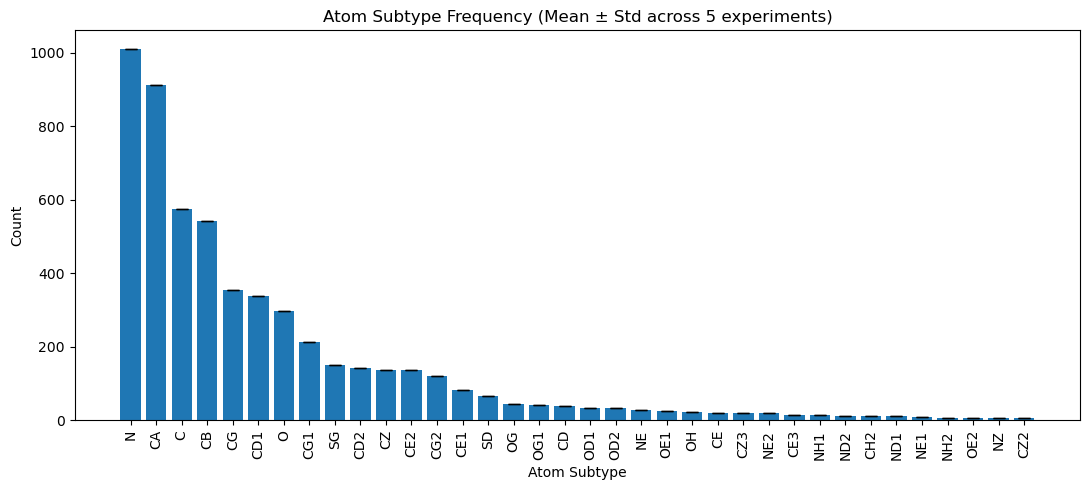

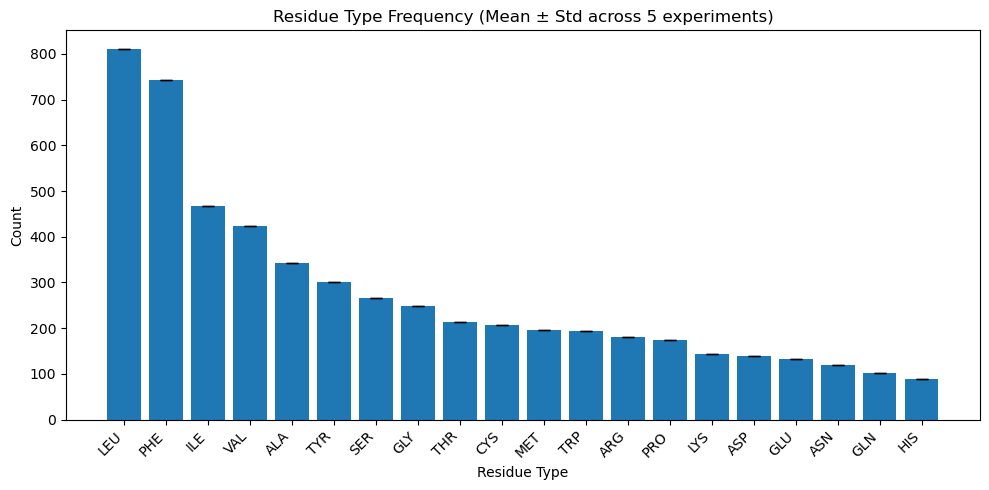

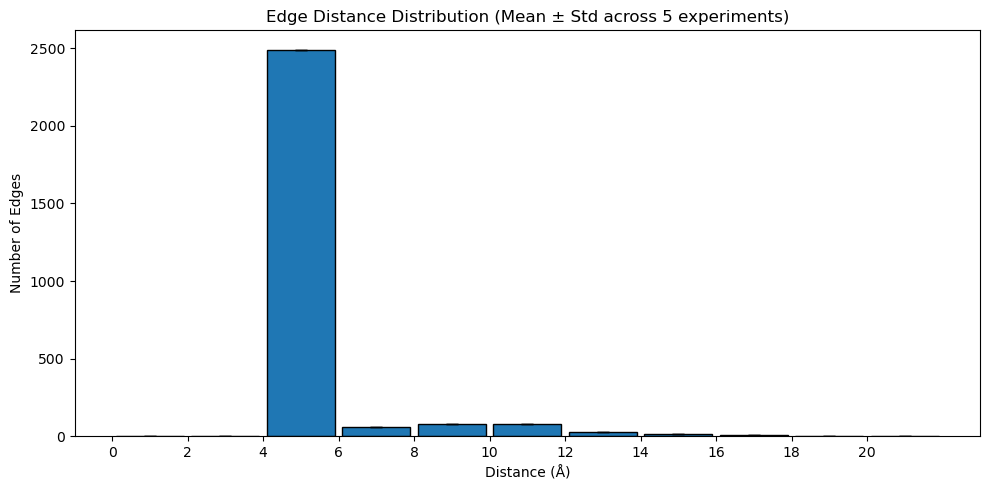

In [7]:
# ===== helper to compute mean/std across experiments for categorical bars =====
def mean_std_bars(counters, top_n=None):
    # union of all keys across experiments
    labels = sorted(set().union(*[c.keys() for c in counters]))
    mat = np.array([[c.get(lbl, 0) for lbl in labels] for c in counters], dtype=float)
    means = mat.mean(axis=0)
    stds  = mat.std(axis=0, ddof=1) if mat.shape[0] > 1 else np.zeros_like(means)
    order = np.argsort(-means)  # sort by mean desc

    if top_n is not None:
        order = order[:top_n]

    return [labels[i] for i in order], means[order], stds[order]

# ===== 1) Atom subtype: mean ± std =====
atom_labels, atom_means, atom_stds = mean_std_bars(atom_counts_per_exp)
plt.figure(figsize=(11, 5))
x = np.arange(len(atom_labels))
plt.bar(x, atom_means, yerr=atom_stds, capsize=4)
plt.xticks(x, atom_labels, rotation=90)
plt.title("Atom Subtype Frequency (Mean ± Std across 5 experiments)")
plt.xlabel("Atom Subtype")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ===== 2) Residue type: mean ± std =====
res_labels, res_means, res_stds = mean_std_bars(residue_counts_per_exp, top_n=20)
plt.figure(figsize=(10, 5))
x = np.arange(len(res_labels))
plt.bar(x, res_means, yerr=res_stds, capsize=4)
plt.xticks(x, res_labels, rotation=45, ha='right')
plt.title("Residue Type Frequency (Mean ± Std across 5 experiments)")
plt.xlabel("Residue Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ===== 3) Distance histogram: mean ± std per bin =====
# use a fixed bin width (2 Å to match your ticks)
bin_width = 2.0
all_dists = np.concatenate([np.array(d) for d in distances_per_exp]) if distances_per_exp else np.array([0.0])
max_d = math.ceil(all_dists.max()) if all_dists.size else 0
# ensure at least one bin
max_edge = max(bin_width, math.ceil(max_d / bin_width) * bin_width)
bin_edges = np.arange(0.0, max_edge + bin_width + 1e-9, bin_width)

# per-experiment hist counts with same bins
hists = []
for dlist in distances_per_exp:
    hist, _ = np.histogram(dlist, bins=bin_edges)
    hists.append(hist.astype(float))
H = np.vstack(hists) if hists else np.zeros((1, len(bin_edges)-1))
hist_means = H.mean(axis=0)
hist_stds  = H.std(axis=0, ddof=1) if H.shape[0] > 1 else np.zeros_like(hist_means)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
plt.figure(figsize=(10, 5))
plt.bar(bin_centers, hist_means, width=bin_width*0.9, yerr=hist_stds, capsize=4, align='center', edgecolor='black')
plt.title("Edge Distance Distribution (Mean ± Std across 5 experiments)")
plt.xlabel("Distance (Å)")
plt.ylabel("Number of Edges")
plt.xticks(np.arange(0, max_edge + 1e-9, 2.0))  # tick every 2 Å like before
plt.tight_layout()
plt.show()

Top 10 edges by importance:
src_res tgt_res src_atom tgt_atom  importance  distance        sample_file
    ALA     GLN      NE2       CB    0.464678  5.717249 5IUA-f3_graphs.npy
    ALA     LEU       CA       CA    0.415980  5.417782 8IRV-f1_graphs.npy
    LYS     ARG      NH2       CB    0.414297 11.671330 1ZHY-f3_graphs.npy
    LEU     LEU       CA       CA    0.413917  5.386831 7F6G-f4_graphs.npy
    LEU     LEU       CA       CA    0.411729  6.014453 8IRV-f1_graphs.npy
    MET     LEU        O        O    0.396572  5.116458 8IRV-f1_graphs.npy
    MET     ALA        O        O    0.381636  6.477056 8IRV-f1_graphs.npy
    ASP     TYR       CB        N    0.371665  4.241192 7XER-f1_graphs.npy
    GLU     LEU        O       CG    0.369741  9.381423 1ZHY-f3_graphs.npy
    VAL     LEU       CA       CA    0.366743  9.045814 7F6G-f4_graphs.npy
    HIS     GLY      NE2        C    0.361284  8.471306 8IRR-f1_graphs.npy
    PHE     TRP        O        O    0.355579  4.968422 7NA8-f3_graphs.n

/tmp/ipykernel_3482122/3654694531.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["pair", "dist_bin"])
/tmp/ipykernel_3482122/3654694531.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.sort_values(["pair","dist_bin","importance","distance"],


Forced-included edges (top 3 per ASN/HIS):
  res_a res_b  importance_val  distance_val
0   ASP   LEU        2.707205      4.382105
1   ARG   HIS        2.464032      4.538463
2   GLU   LEU        2.914123      4.237775
3   LEU   LYS        2.976296      5.662087


/tmp/ipykernel_3482122/3654694531.py:287: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.18)


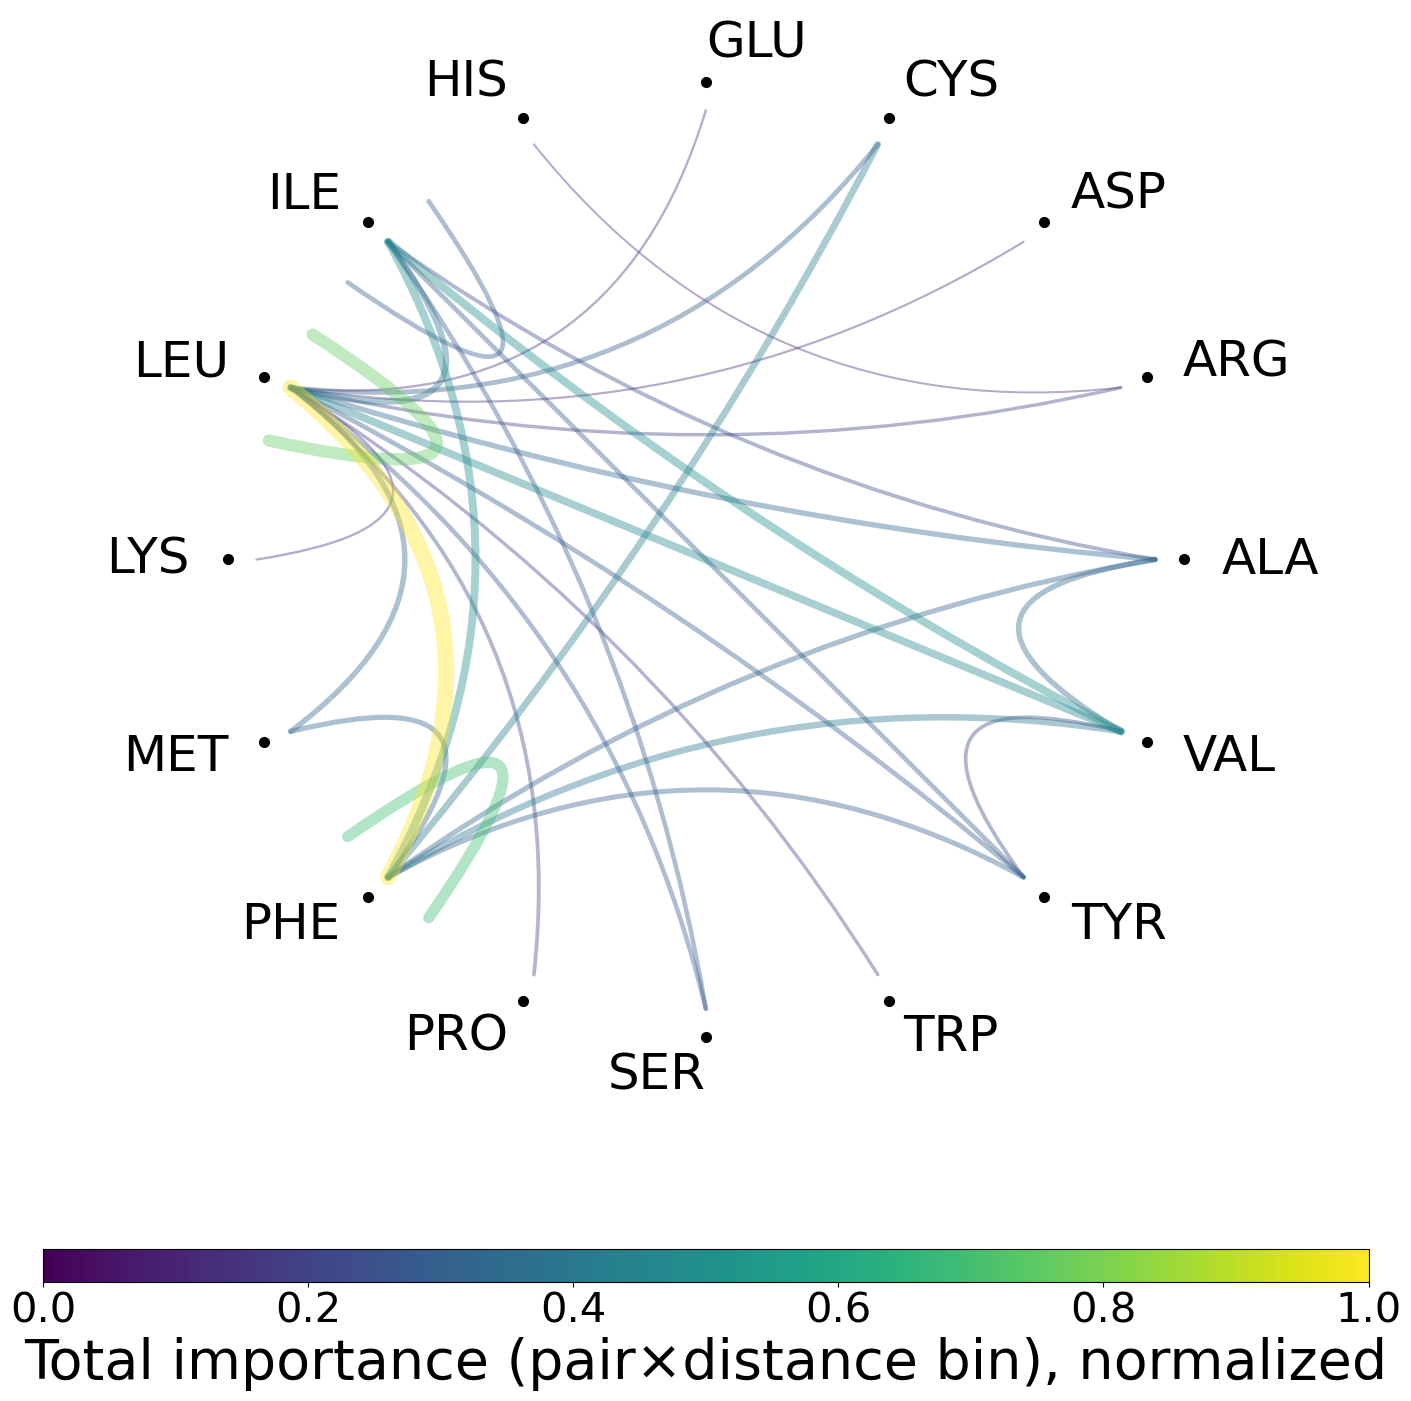

In [14]:
edges_df = pd.DataFrame(edge_records)
if edges_df.empty:
    raise ValueError("No edges collected; edge_records is empty.")

filtered_df = edges_df[edges_df["distance"] >= 4]

# Sort by importance descending and get top 10
top_edges = filtered_df.sort_values("importance", ascending=False)
print("Top 10 edges by importance:")
print(top_edges[["src_res", "tgt_res", "src_atom", "tgt_atom", "importance", "distance", "sample_file"]].to_string(index=False))

if filtered_df.empty:
    raise ValueError("filtered_df is empty (no edges at distance ≥ 3).")

# Remove edges where src or tgt residue is GLU or MET
filtered_df = filtered_df[
    ~(
        filtered_df["src_res"].isin(["GLY", "THR"]) |
        filtered_df["tgt_res"].isin(["GLY", "THR"])
    )
]

df = filtered_df.copy()

# 1) Treat residue connections as undirected pairs
df["res_a"] = df.apply(lambda x: min(x["src_res"], x["tgt_res"]), axis=1)
df["res_b"] = df.apply(lambda x: max(x["src_res"], x["tgt_res"]), axis=1)
df["pair"]  = df["res_a"] + "-" + df["res_b"]

# ----- Distance binning -----
bin_edges  = [4, 8, 12, 16, 20, np.inf]
bin_labels = ["4–<8 Å", "8–<12 Å", "12–<16 Å", "16–<20 Å", "≥20 Å"]
df["dist_bin"] = pd.cut(df["distance"], bins=bin_edges, labels=bin_labels, right=False)
df["pair_bin"] = df["pair"] + " | " + df["dist_bin"].astype(str)

# Define the importance threshold
cutoff = 0.30
df["is_important"] = df["importance"] >= cutoff

# ----- Aggregations per (pair, bin) -----
pair_bin_stats = (
    df.groupby(["pair", "dist_bin"])
      .agg(
          count             = ("importance", "size"),
          total_importance  = ("importance", "sum"),
          avg_importance    = ("importance", "mean"),
          max_importance    = ("importance", "max"),
          count_importance=("is_important", "sum"),               # ≥ 0.3
          #count_unimportant=("is_important", lambda x: (~x).sum())  # < 0.3
      )
      .rename(columns={"count_importance": "count_importance>0.3"})
      .sort_values(["total_importance", "avg_importance", "count"], ascending=False)
)

print("\n=== Residue Pair Instances by Distance Bin (ranked) ===")
print(pair_bin_stats.to_string())

# --- Normalize total_importance to [0, 1] for coloring ---
pbs = pair_bin_stats.reset_index()
tmin = pbs["total_importance"].min()
tmax = pbs["total_importance"].max()
if tmax > tmin:
    pbs["color_val"] = (pbs["total_importance"] - tmin) / (tmax - tmin)
else:
    # all totals equal (or only one); color them all as 1.0
    pbs["color_val"] = 1.0

# --- Pick only the highest edge per (pair, dist_bin) ---
# tie-breakers: highest importance, then shortest distance (optional), then first
best_edges = (
    df.sort_values(["pair","dist_bin","importance","distance"],
                   ascending=[True, True, False, True])
      .groupby(["pair","dist_bin"], as_index=False)
      .head(1)
      .copy()
)

# --- Attach normalized color to each chosen edge ---
best_edges = best_edges.merge(
    pbs[["pair","dist_bin","color_val","total_importance"]],
    on=["pair","dist_bin"],
    how="left"
)

# --- Columns expected by your plotter ---
best_edges["importance_val"] = best_edges["total_importance"]
best_edges["distance_val"]   = best_edges["distance"]

# ----- (Optional) Ensure every pair is listed for EVERY bin (zero-fill for missing bins) -----
all_pairs = df["pair"].unique()
full_index = pd.MultiIndex.from_product([all_pairs, bin_labels], names=["pair", "dist_bin"])
pair_bin_stats_full = pair_bin_stats.reindex(full_index, fill_value=0)

print("\n=== Residue Pair Instances by Distance Bin (full grid, zero-filled) ===")
print(pair_bin_stats_full.to_string())

# ----- (Optional) Pivot to a compact table: counts per bin for each pair -----
pair_bin_counts = (
    pair_bin_stats_full["count"]
      .unstack("dist_bin")
      .fillna(0)
      .astype(int)
      .loc[  # order pairs by total importance across all bins
          pair_bin_stats_full.groupby(level=0)["total_importance"].sum().sort_values(ascending=False).index
      ]
)

print("\n=== Counts per Distance Bin (rows = residue pair) ===")
print(pair_bin_counts.to_string())

# ----- (Optional) Merge pair-level ranking with per-bin counts for one table -----
pair_level_rank = (
    df.groupby("pair")
      .agg(count=("importance","size"),
           total_importance=("importance","sum"),
           avg_importance=("importance","mean"))
      .sort_values(["total_importance","avg_importance","count"], ascending=False)
)

merged_pair_summary = pair_level_rank.join(pair_bin_counts, how="left").fillna(0)
print("\n=== Pair Ranking + Counts per Distance Bin ===")
print(merged_pair_summary.to_string())

# Treat residue pairs as undirected, but keep all rows (no aggregation)
edges_df["res_a"] = edges_df.apply(lambda x: min(x["src_res"], x["tgt_res"]), axis=1)
edges_df["res_b"] = edges_df.apply(lambda x: max(x["src_res"], x["tgt_res"]), axis=1)

# For plotting, we'll use the raw per-edge values
edges_df["importance_val"] = edges_df["importance"]
edges_df["distance_val"]   = edges_df["distance"]

def plot_residue_chord_raw(
    df,
    importance_col="importance_val",   # still used for edge width
    distance_col="distance_val",
    color_col="color_val",             # <-- NEW: use normalized total_importance for color
    top_k=50,
    node_order=None,
    figsize=(14, 14),
    title_size=26,
    node_label_size=36,
    distance_fontsize=26,
    tick_label_size=30,
    cbar_label_size=40,
    edge_alpha=0.4,
    curvature=0.55,
    cmap_name="viridis",
    pad=0.45,
    node_inset=0.94,
    label_inset=0.97,
    clip_edges=True,
    dist_min=4,
    dist_max=None,
    label_top_n=0,
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.path import Path
    from matplotlib.patches import PathPatch, Circle
    from matplotlib import colors

    rc = {
        "font.size": tick_label_size,
        "axes.titlesize": title_size,
        "axes.labelsize": tick_label_size,
        "xtick.labelsize": tick_label_size,
        "ytick.labelsize": tick_label_size,
        "legend.fontsize": tick_label_size,
        "figure.titlesize": title_size,
    }

    # Distance filters (operate on the column passed in)
    if dist_min is not None:
        df = df[df[distance_col] >= dist_min]
    if dist_max is not None:
        df = df[df[distance_col] <= dist_max]

    if df.empty:
        raise ValueError("No edges to plot after distance filter.")

    # Only keep top_k rows (data already pre-filtered to best per pair×bin)
    df = df.sort_values(importance_col, ascending=False).head(top_k).copy()
    label_indices = set(df.head(min(label_top_n, len(df))).index)

    df_plot = df.sort_values(importance_col, ascending=True)

    nodes = node_order or sorted(set(df["res_a"]).union(set(df["res_b"])))
    n = len(nodes)
    node_to_idx = {r: i for i, r in enumerate(nodes)}
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    R = 1.0
    coords = np.c_[R*np.cos(angles), R*np.sin(angles)]

    # --- Color mapping from normalized color_col in [0,1] ---
    # If missing or degenerate, fall back to zeros.
    color_vals = (df[color_col] if color_col in df.columns
              else pd.Series(0.0, index=df.index)).to_numpy().astype(float)
    color_vals = np.clip(color_vals, 0.0, 1.0)
    norm = colors.Normalize(vmin=0.0, vmax=1.0)
    cmap = plt.get_cmap(cmap_name)

    # Edge width still based on per-edge importance (can change if you want)
    imp_vals = df[importance_col].to_numpy().astype(float)
    imp_min, imp_max = np.percentile(imp_vals, 2), np.percentile(imp_vals, 98)
    if imp_min == imp_max:
        imp_min, imp_max = imp_vals.min(), imp_vals.max()
    if imp_min == imp_max:
        imp_min, imp_max = 0.0, 1.0

    def width_fn(v, mn=1.5, mx=10.0):
        return mn + (mx - mn) * ((v - imp_min) / (imp_max - imp_min) if imp_max > imp_min else 0.5)

    def color_fn(v):
        return cmap(norm(v))  # v is already 0..1

    with plt.rc_context(rc):
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
        ax.set_aspect("equal")
        ax.axis("off")

        # nodes + labels
        label_r = 1.08
        for i, r in enumerate(nodes):
            x, y = coords[i]
            ax.plot([x], [y], "o", ms=7, color="black")
            lx, ly = label_r*np.cos(angles[i]), label_r*np.sin(angles[i])
            ha = "left" if lx >= 0 else "right"
            ax.text(lx, ly, r, ha=ha, va="center", fontsize=node_label_size)

        clip_circle = Circle((0, 0), 1.0, transform=ax.transData) if clip_edges else None

        def _quad(p0, p1, p2, t):
            return (1-t)**2*p0 + 2*(1-t)*t*p1 + t**2*p2

        # draw edges
        for idx, row in df_plot.iterrows():
            a = node_to_idx[row["res_a"]]; b = node_to_idx[row["res_b"]]
            show_label = idx in label_indices
            w = width_fn(float(row[importance_col]))
            c = color_fn(float(row[color_col]))

            if a == b:
                p = coords[a] * node_inset
                t = p[::-1] * np.array([-1, 1]); t = t / (np.linalg.norm(t) + 1e-12)
                loop_width = 0.12; loop_curv = 0.70
                p0 = p + t * loop_width
                p2 = p - t * loop_width
                p1 = (1.0 - loop_curv) * p
                path  = Path(np.vstack([p0, p1, p2]), [Path.MOVETO, Path.CURVE3, Path.CURVE3])
                patch = PathPatch(path, lw=w, edgecolor=c, facecolor="none",
                                  alpha=edge_alpha, capstyle="round", clip_on=True)
                if clip_circle is not None: patch.set_clip_path(clip_circle)
                ax.add_patch(patch)
                if show_label:
                    mid_xy = (p + t * (loop_width * 0.3)) * label_inset
                    txt = ax.text(mid_xy[0], mid_xy[1], f'{row[distance_col]:.1f} Å',
                                  fontsize=distance_fontsize, ha="center", va="center",
                                  bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.7))
                    if clip_circle is not None: txt.set_clip_path(clip_circle)
                continue

            p0 = coords[a]*node_inset
            p2 = coords[b]*node_inset
            p_mid = 0.5*(p0+p2)
            p1 = (1.0-curvature)*p_mid
            path = Path(np.vstack([p0, p1, p2]), [Path.MOVETO, Path.CURVE3, Path.CURVE3])
            patch = PathPatch(path, lw=w, edgecolor=c, facecolor="none",
                              alpha=edge_alpha, capstyle="round", clip_on=True)
            if clip_circle is not None: patch.set_clip_path(clip_circle)
            ax.add_patch(patch)

            if show_label:
                mid_xy = _quad(p0, p1, p2, 0.5) * label_inset
                txt = ax.text(mid_xy[0], mid_xy[1], f'{row[distance_col]:.1f} Å',
                              fontsize=distance_fontsize, ha="center", va="center",
                              bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.7))
                if clip_circle is not None: txt.set_clip_path(clip_circle)

        # colorbar for normalized total_importance
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.12, aspect=40)
        cbar.set_label('Total importance (pair×distance bin), normalized', fontsize=cbar_label_size)
        cbar.ax.tick_params(labelsize=tick_label_size)

        lim = 1.15
        ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
        fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.18)
        ax.set_aspect("equal")
        return fig, ax


target_residues = ["ASP", "HIS", "GLU", "LYS"]
top_k = 30  # total edges you want on the plot

# --- Top 3 edges per target residue (ASN, HIS) ---
edges_with_targets_list = []

for res in target_residues:
    sub = best_edges[(best_edges["res_a"] == res) | (best_edges["res_b"] == res)]
    sub_top1 = sub.sort_values("importance_val", ascending=False).head(1)
    edges_with_targets_list.append(sub_top1)

edges_with_targets = (
    pd.concat(edges_with_targets_list, ignore_index=True)
      .drop_duplicates()
)

print("Forced-included edges (top 3 per ASN/HIS):")
print(edges_with_targets[["res_a","res_b","importance_val","distance_val"]])

# --- Fill remaining slots with other important edges ---
remaining_needed = max(0, top_k - len(edges_with_targets))

other_edges = best_edges.drop(edges_with_targets.index)
other_top = other_edges.sort_values("importance_val", ascending=False).head(remaining_needed)

# Final set for plotting
edges_for_plot = (
    pd.concat([edges_with_targets, other_top], ignore_index=True)
      .drop_duplicates()
)

# Call the plotter, don’t trim again inside
fig, ax = plot_residue_chord_raw(
    edges_for_plot,
    importance_col="importance_val",
    distance_col="distance_val",
    color_col="color_val",
    top_k=len(edges_for_plot)  # use everything we selected
)




In [9]:
import pandas as pd

data = np.load("../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/Test/Positive/4BOE-filtered_graphs.npy", allow_pickle=True).item()
inverse_distance = data['inverse_distance']
encoded_matrix = data['encoded_matrix']

print(inverse_distance.shape)
print(encoded_matrix.shape)



FileNotFoundError: [Errno 2] No such file or directory: '../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/Test/Positive/4BOE-filtered_graphs.npy'

In [ ]:
rows = get_edge_node_features(df, encoded_matrix, top_k=50)

for r in rows:
    print(f"\nEdge: {r['source_idx']} -> {r['target_idx']}")
    print("Source:", r['source_features'], "Atom:", r['source_atom'])
    print("Target:", r['target_features'], "Atom:", r['target_atom'])
    print("Importance:", r['importance'])


In [ ]:
from Bio.PDB import PDBParser
import numpy as np

# Load the structure
pdb_file = "../GNN/filtered-pdbs-distinct-5A/positive/6PS5-filtered.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("structure_id", pdb_file)

# Get all atoms
atoms = list(structure.get_atoms())

# Check enough atoms exist
if len(atoms) >= 54:
    atom1 = atoms[35]  # 36th atom
    atom2 = atoms[47]  # 54th atom

    coord1 = atom1.coord
    coord2 = atom2.coord

    # Print atom 1 info
    print("Atom 1:")
    print("  Name:", atom1.get_name())
    print("  Element:", atom1.element)
    print("  Coordinates:", coord1)
    print("  Residue:", atom1.get_parent().get_resname())
    print("  Chain ID:", atom1.get_parent().get_parent().id)
    print("  Residue ID:", atom1.get_parent().id)

    # Print atom 2 info
    print("\nAtom 2:")
    print("  Name:", atom2.get_name())
    print("  Element:", atom2.element)
    print("  Coordinates:", coord2)
    print("  Residue:", atom2.get_parent().get_resname())
    print("  Chain ID:", atom2.get_parent().get_parent().id)
    print("  Residue ID:", atom2.get_parent().id)

    # Compute distance
    distance = np.linalg.norm(coord1 - coord2)
    print(f"\nEuclidean distance between atom 36 and atom 54: {distance:.3f} Å")

else:
    print("PDB file has fewer than 54 atoms.")


In [ ]:
pdb_files = glob.glob("Notebooks/Cholesterol/GNN/ivan-pdbs-distinct-5A/positive/*.pdb")